In [1]:
import random
import re
import sys

import matplotlib.pyplot as plt
import numpy as np

import cvrplib
from aco import solve_instance, SET_A, SET_B, SET_E


iters_limit = 10000
iters_stagnation_limit = 1000

seed = 123

Расчет ошибки

Start optimization A-n32-k5
Start optimization A-n33-k5
Start optimization A-n33-k6
Start optimization A-n34-k5
Start optimization A-n36-k5
Start optimization A-n37-k5
Start optimization A-n37-k6
Start optimization A-n38-k5
Start optimization A-n39-k5
Start optimization A-n39-k6
Start optimization A-n44-k6
Start optimization A-n45-k6
Start optimization A-n45-k7
Start optimization A-n46-k7
Start optimization A-n48-k7
Start optimization A-n53-k7
Start optimization A-n54-k7
Start optimization A-n55-k9
Start optimization A-n60-k9
Start optimization A-n61-k9
Start optimization A-n62-k8
Start optimization A-n63-k9
Start optimization A-n63-k10
Start optimization A-n64-k9
Start optimization A-n65-k9
Start optimization A-n69-k9
Start optimization A-n80-k10


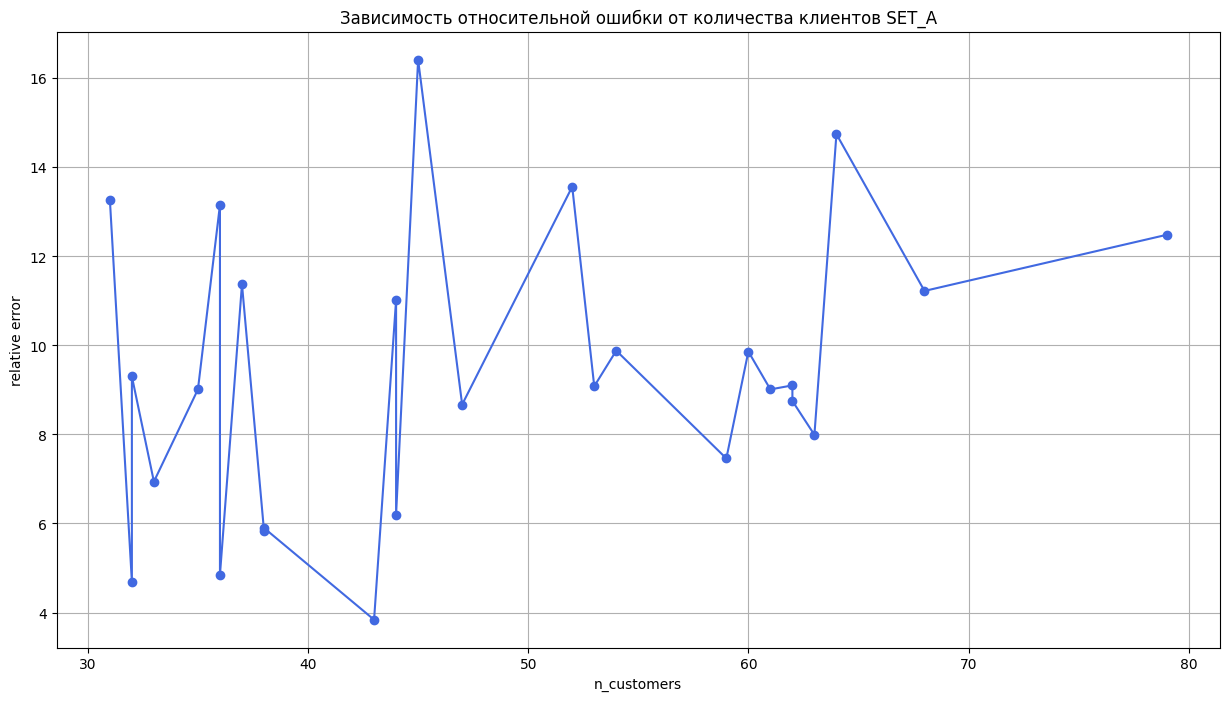

In [2]:
n_customers = []
errors = []

for sample in SET_A:
    route, cost, n_cars = solve_instance(
        instance_name=sample, alpha=0.2, beta=3, q0=0.8, n_ants=50
    )

    instance, solution = cvrplib.download(sample, solution=True)

    error = round(abs(solution.cost - cost) / solution.cost * 100, 2)

    n_customers.append(instance.n_customers)
    errors.append(error)

plt.figure(figsize=(15, 8))
plt.plot(n_customers, errors, "o-", color="royalblue")
plt.grid(True)
plt.xlabel("n_customers")
plt.ylabel("relative error")
plt.title("Зависимость относительной ошибки от количества клиентов SET_A")
plt.show()

Start optimization B-n31-k5
Start optimization B-n34-k5
Start optimization B-n35-k5
Start optimization B-n38-k6
Start optimization B-n39-k5
Start optimization B-n41-k6
Start optimization B-n43-k6
Start optimization B-n44-k7
Start optimization B-n45-k5
Start optimization B-n45-k6
Start optimization B-n50-k7
Start optimization B-n50-k8
Start optimization B-n51-k7
Start optimization B-n52-k7
Start optimization B-n56-k7
Start optimization B-n57-k7
Start optimization B-n57-k9
Start optimization B-n63-k10
Start optimization B-n64-k9
Start optimization B-n66-k9
Start optimization B-n67-k10
Start optimization B-n68-k9
Start optimization B-n78-k10


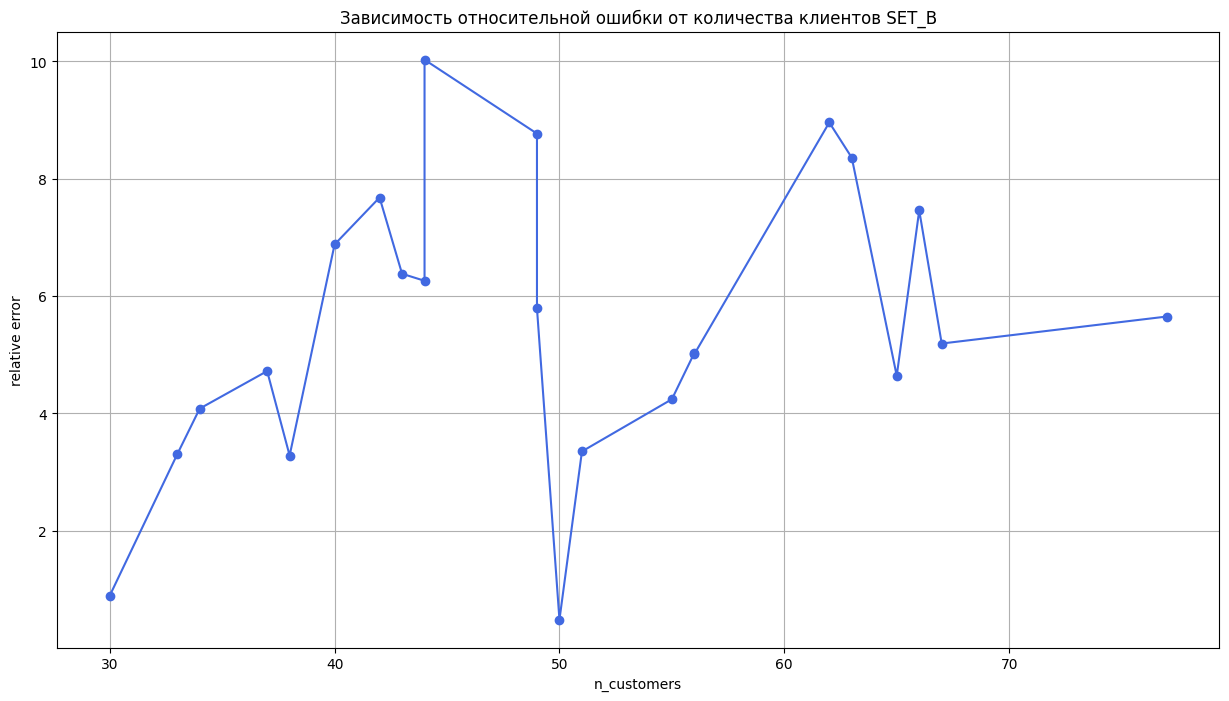

In [3]:
n_customers = []
errors = []

for sample in SET_B:
    route, cost, n_cars = solve_instance(
        instance_name=sample, alpha=0.8, beta=3, q0=0.8, n_ants=50
    )

    instance, solution = cvrplib.download(sample, solution=True)

    error = round(abs(solution.cost - cost) / solution.cost * 100, 2)

    n_customers.append(instance.n_customers)
    errors.append(error)

plt.figure(figsize=(15, 8))
plt.plot(n_customers, errors, "o-", color="royalblue")
plt.grid(True)
plt.xlabel("n_customers")
plt.ylabel("relative error")
plt.title("Зависимость относительной ошибки от количества клиентов SET_B")
plt.show()

Start optimization E-n13-k4
Start optimization E-n22-k4
Start optimization E-n23-k3
Start optimization E-n30-k3
Start optimization E-n31-k7
Start optimization E-n33-k4
Start optimization E-n51-k5
Start optimization E-n76-k7
Start optimization E-n76-k8
Start optimization E-n76-k10
Start optimization E-n76-k14
Start optimization E-n101-k8
Start optimization E-n101-k14


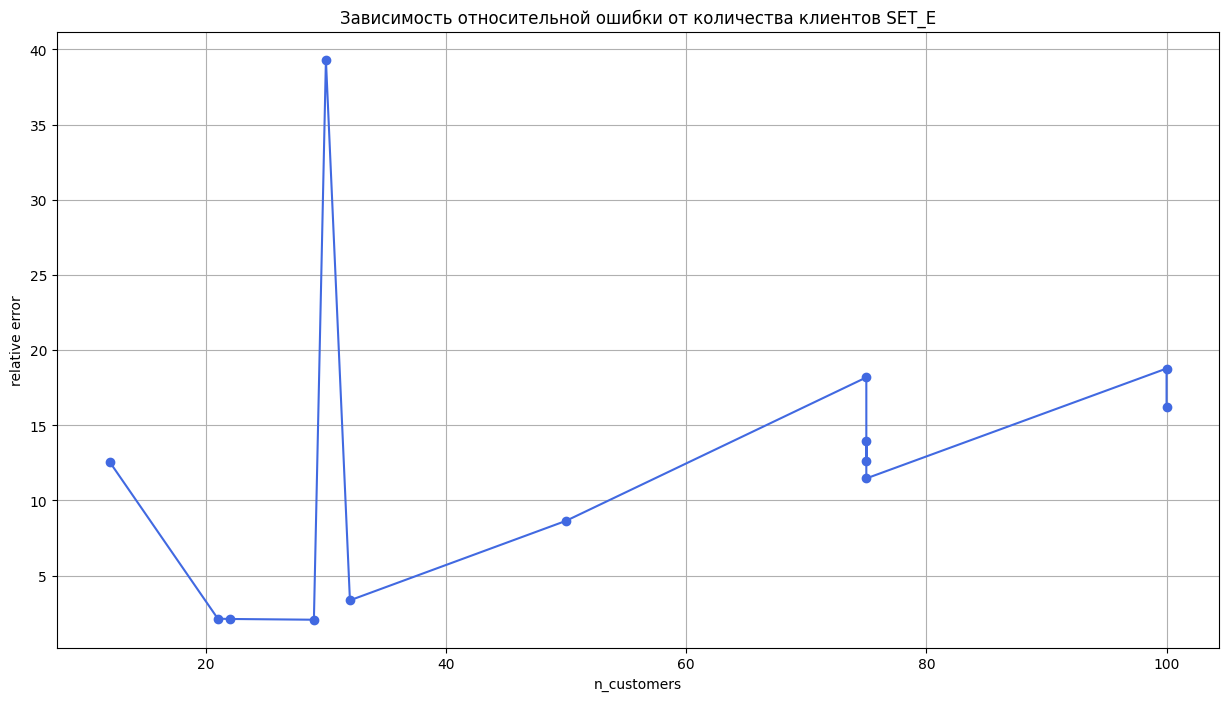

In [4]:
n_customers = []
errors = []

for sample in SET_E:
    route, cost, n_cars = solve_instance(
        instance_name=sample, alpha=0.4, beta=3, q0=0.8, n_ants=50
    )

    instance, solution = cvrplib.download(sample, solution=True)

    error = round(abs(solution.cost - cost) / solution.cost * 100, 2)

    n_customers.append(instance.n_customers)
    errors.append(error)

plt.figure(figsize=(15, 8))
plt.plot(n_customers, errors, "o-", color="royalblue")
plt.grid(True)
plt.xlabel("n_customers")
plt.ylabel("relative error")
plt.title("Зависимость относительной ошибки от количества клиентов SET_E")
plt.show()

In [5]:
# Download instances
instance, solution = cvrplib.download("B-n51-k7", solution=True)

In [6]:
def find_customer_groups(distance_matrix, n_customers, demands):
    customer_groups = [0]
    for i in range(1, n_customers + 1):
        for j in range(i + 1, n_customers + 1):
            # print(i)
            if distance_matrix[i][j] == 0:
                if j not in customer_groups:
                    customer_groups.append(j)
                demands[i] = instance.demands[i] + instance.demands[j]
                print(i, j)
    return customer_groups, demands


def init_tau(distance_matrix, n_customers):
    most_consuming_edge = 0
    for i in range(n_customers):
        for j in range(n_customers):
            if (
                distance_matrix[i][j] != 0
                and distance_matrix[i][j] > most_consuming_edge
            ):
                most_consuming_edge = distance_matrix[i][j]

    tau = ((n_customers) * most_consuming_edge) ** (-1)
    return tau

In [8]:
def aco_optimization(alpha, beta, qO, p, n_ants):
    print("Start initialization")

    best_route = []
    minimal_route_cost = 50000
    iter = 1
    stagnation_iter = 0

    np.random.seed(123)
    random.seed(123)

    distance_matrix = tuple(instance.distances)
    capacity = instance.capacity
    customers = instance.customers
    n_customers = instance.n_customers
    demands = instance.demands.copy()

    customer_groups, demands = find_customer_groups(
        distance_matrix, n_customers, demands
    )
    print(f"debug {demands == instance.demands}")

    tau = init_tau(distance_matrix, n_customers)
    pheromon_matrix = tuple(
        [tau for _ in range(n_customers + 1)] for _ in range(n_customers + 1)
    )
    print("Start optimization")

    # Зададим количество итерации и итерации стагнации
    while (iter <= iters_limit) and (stagnation_iter <= iters_stagnation_limit):
        for ant in range(n_ants):
            print(f"Create ant#{ant}")
            current_route = [0]
            non_visited_customers = list(range(1, n_customers + 1))

            for group_id in range(1, len(customer_groups)):
                non_visited_customers.remove(customer_groups[group_id])

            capacity_remains = capacity
            vehicles = 1

            # Посещаем клиентов
            while len(non_visited_customers) > 0:
                current_customer = current_route[-1]

                # preferences (предпочтения) равны феромону умноженному на обратное расстояние
                preferences = np.array(
                    [
                        (pheromon_matrix[current_customer][customer] ** (alpha))
                        * ((1 / distance_matrix[current_customer][customer]) ** beta)
                        for customer in non_visited_customers
                        if (
                            customer not in current_route
                            and distance_matrix[current_customer][customer] != 0
                        )
                    ]
                )

                if np.random.random_sample() < qO:
                    # Идём по пути максимального предпочтения
                    next_customer = non_visited_customers[np.argmax(preferences)]
                else:
                    # Идём по некоторому "случайному" пути
                    next_customer = np.random.choice(
                        non_visited_customers, p=preferences / sum(preferences)
                    )

                capacity_remains -= demands[next_customer]

                if capacity_remains < 0:
                    # Если машина заполнена полностью - отправляем на склад
                    current_route.append(0)
                    capacity_remains = capacity
                    vehicles += 1
                else:
                    non_visited_customers.remove(next_customer)
                    current_route.append(next_customer)

            current_route.append(0)
            iter += 1
            current_route_cost = 0

            # Считаем матрицу феромонов и общую длину пути
            for i in range(1, len(current_route)):
                # Локальное обновление феромона
                p1, p2 = current_route[i - 1], current_route[i]
                pheromon_matrix[p1][p2] = pheromon_matrix[p2][p1] = (
                    pheromon_matrix[p1][p2] * (1 - alpha) + alpha * tau
                )
                current_route_cost += distance_matrix[p1][p2]

            # Проверяем, является ли этот путь лучше предыдущего
            if current_route_cost < minimal_route_cost:
                best_route = current_route.copy()
                minimal_route_cost = current_route_cost
                stagnation_iter += -1
            else:
                stagnation_iter += 1

        for i in range(1, len(best_route)):
            # Глобальное обновление феромона
            p_1, p_2 = best_route[i - 1], best_route[i]
            pheromon_matrix[p_1][p_2] = pheromon_matrix[p_2][p_1] = (
                pheromon_matrix[p_1][p_2] * (1 - alpha)
                + 10 * alpha / current_route_cost
            )

        print(iter)
        print(stagnation_iter)
    return (best_route, minimal_route_cost, vehicles)

In [17]:
best_route, minimal_route_cost, avto = aco_optimization(
    alpha=2, beta=3, qO=0.4, p=0.6, n_ants=50
)

Start initialization
15 23
15 50
23 50
45 47
debug False
Start optimization
Create ant#0
Create ant#1
Create ant#2
Create ant#3
Create ant#4
Create ant#5
Create ant#6
Create ant#7
Create ant#8
Create ant#9
Create ant#10
Create ant#11
Create ant#12
Create ant#13
Create ant#14
Create ant#15
Create ant#16
Create ant#17
Create ant#18
Create ant#19
Create ant#20
Create ant#21
Create ant#22
Create ant#23
Create ant#24
Create ant#25
Create ant#26
Create ant#27
Create ant#28
Create ant#29
Create ant#30
Create ant#31
Create ant#32
Create ant#33
Create ant#34
Create ant#35
Create ant#36
Create ant#37
Create ant#38
Create ant#39
Create ant#40
Create ant#41
Create ant#42
Create ant#43
Create ant#44
Create ant#45
Create ant#46
Create ant#47
Create ant#48
Create ant#49
51
42
Create ant#0
Create ant#1
Create ant#2
Create ant#3
Create ant#4
Create ant#5
Create ant#6
Create ant#7
Create ant#8
Create ant#9
Create ant#10
Create ant#11
Create ant#12
Create ant#13
Create ant#14
Create ant#15
Create ant#16


In [15]:
def plot_solution(instance, solution, solution_route, solution_cost, solution_n_cars):
    class Color:
        def __init__(self, colors):
            self.colors = colors
            self.update()

        def get(self):
            if len(self.buffer):
                return self.buffer.pop(0)
            else:
                self.update()
                return self.buffer.pop(0)

        def update(self):
            self.buffer = self.colors.copy()

    colors = Color(
        colors=[
            "#D43B39",
            "#1C39BB",
            "#751E1E",
            "#32127A",
            "#D99058",
            "#48317E",
            "#FAE409",
            "#EB83BD",
            "#00A693",
            "#FE28A2",
        ]
    )

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
    fig.suptitle(instance.name)
    for j in range(len(solution.routes)):
        x = [instance.coordinates[0][0]]
        y = [instance.coordinates[0][1]]
        for i in solution.routes[j]:
            x += [instance.coordinates[i][0]]
            y += [instance.coordinates[i][1]]
        x += [instance.coordinates[0][0]]
        y += [instance.coordinates[0][1]]

        ax1.plot(x, y, "-", color=colors.get())
        ax1.scatter(x, y, color="black")
        ax1.scatter(x[0], y[0], color="red", s=100)

        ax1.set_title(
            f"Etalon\nCount cars: {instance.name[-1]} | Cost: {solution.cost}"
        )

    # cars_count = -1
    x = [instance.coordinates[0][0]]
    y = [instance.coordinates[0][1]]
    for i in solution_route:
        x += [instance.coordinates[i][0]]
        y += [instance.coordinates[i][1]]
        # print(x,y)
        ax2.plot(x, y, color=colors.get())
        ax2.scatter(x, y, color="black")
        if i == instance.depot:
            x = [instance.coordinates[i][0]]
            y = [instance.coordinates[i][1]]
            # cars_count += 1

    ax2.scatter(x[0], y[0], color="red", s=100)
    ax2.set_title(f"Solution\nCount cars: {solution_n_cars} | Cost: {solution_cost}")

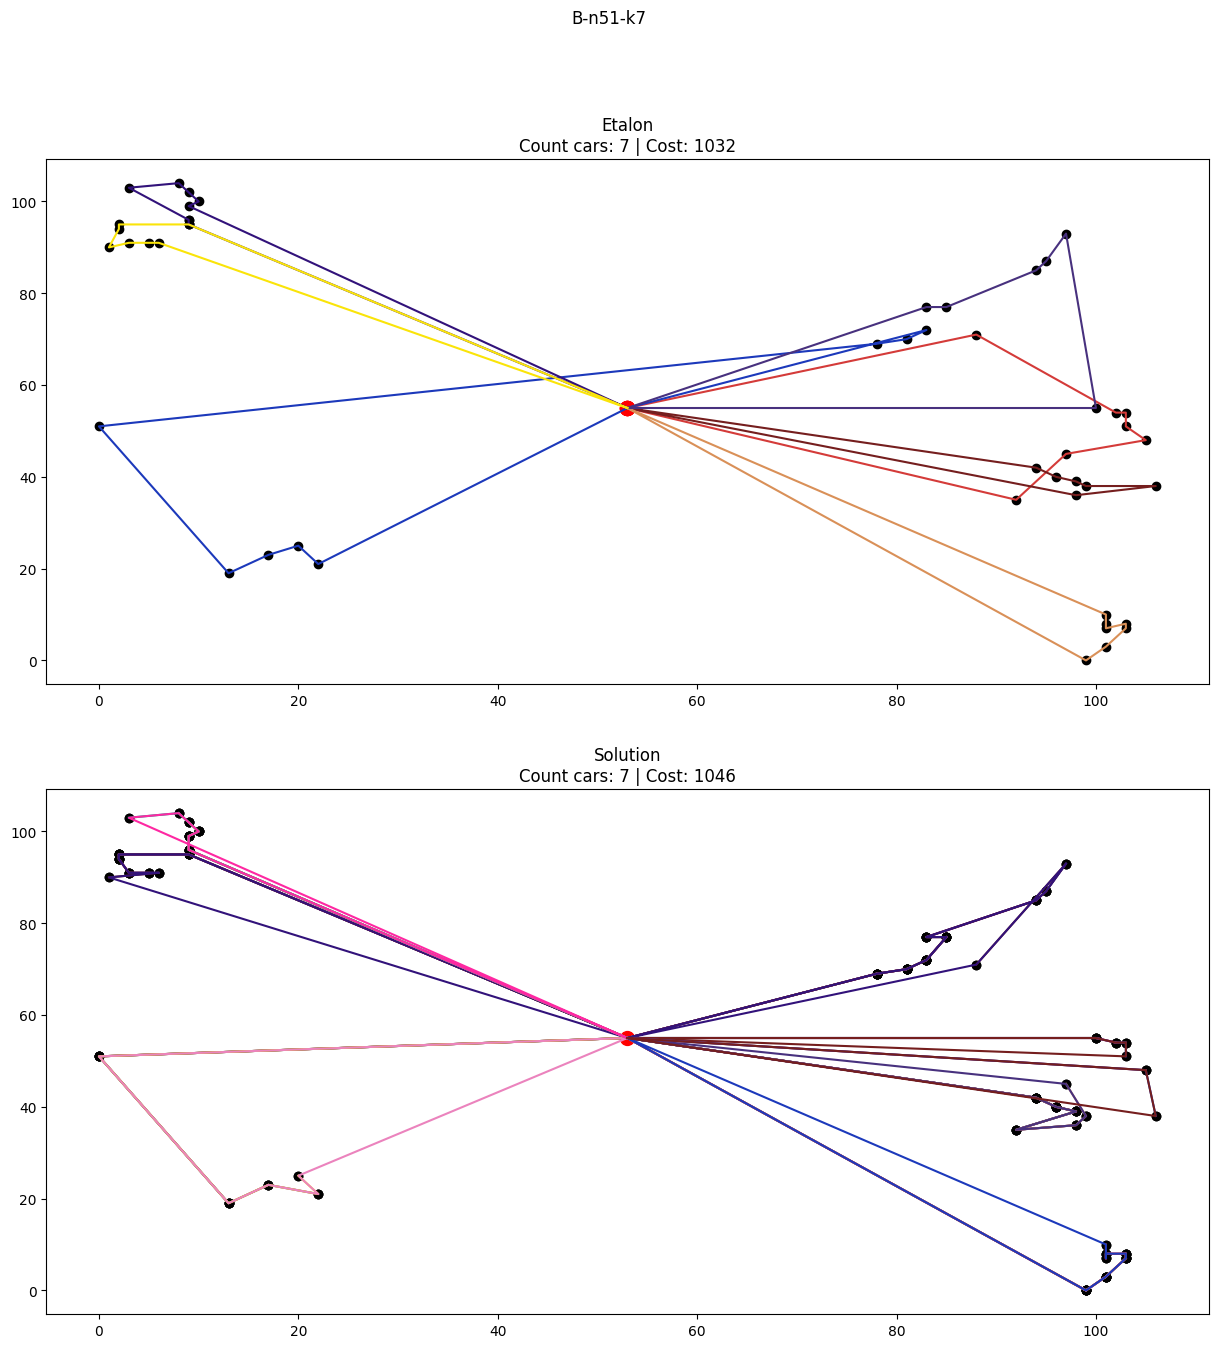

In [18]:
plot_solution(
    instance=instance,
    solution=solution,
    solution_route=best_route,
    solution_cost=minimal_route_cost,
    solution_n_cars=avto,
)

Set A - {'alpha': 0.2, 'beta': 3, 'q0': 0.8} ({'alpha': 0.8, 'beta': 3, 'q0': 0.8})
Set B - {'alpha': 0.8, 'beta': 3, 'q0': 0.8}
Set E - {'alpha': 0.4, 'beta': 3, 'q0': 0.8}